In [87]:
#Import libraries & Load Data 
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


# Define the path to the Excel file
file_path = r"C:\Users\raman\OneDrive\School Related\Prediction_Data.xlsx"

# Define the sheet name to read data from 
sheet_name = "vw_ChurnData"

# Read the data from the specified sheet into a pandas DataFrame
data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the fetched data 
print(data.head())


  Customer_ID  Gender  Age Married       State  Number_of_Referrals  \
0    11596-MO  Female   40      No    Missouri                   15   
1    11604-WA  Female   38     Yes  Washington                    4   
2    11616-IL    Male   26      No    Illinois                    6   
3    11647-FL    Male   44      No     Florida                    2   
4    11647-IL    Male   81      No    Illinois                    1   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                11     Deal 4           Yes             No  ...   
1                 8        NaN           Yes            Yes  ...   
2                 2        NaN           Yes            Yes  ...   
3                 4     Deal 4           Yes            Yes  ...   
4                21        NaN           Yes            Yes  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0  Bank Withdrawal      76.779999    354.890015           0.0   
1  Bank Withdrawal     111.080002 

In [79]:
# Data Processing 

# List of columns to be label encoded
columns_to_encode = [
    'Gender', 'Married', 'State', 'Value_Deal', 'Phone_Service', 'Multiple_Lines', 
    'Internet_Service', 'Internet_Type', 'Online_Security', 'Online_Backup', 
    'Device_Protection_Plan', 'Premium_Support', 'Streaming_TV', 'Streaming_Movies', 
    'Streaming_Music', 'Unlimited_Data', 'Contract', 'Paperless_Billing', 
    'Payment_Method'
]

# Encode categorical variables except the target variable 
label_encoders = {}
for column in columns_to_encode: 
    label_encoders[column] = LabelEncoder()
    data[column] = label_encoders[column].fit_transform(data[column])

# Manually encode the target variable 'Customer_Status' 
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

# Drop any non-numeric columns left over (like IDs or free-text)
non_numeric_cols = data.select_dtypes(include=['object']).columns.tolist()
print("Dropping non-numeric columns:", non_numeric_cols)
data = data.drop(columns=non_numeric_cols)

# Split data into features and target (independent and dependent)
X = data.drop('Customer_Status', axis=1)
y = data['Customer_Status']

# Split data into training and testing sets 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Dropping non-numeric columns: ['Customer_ID', 'Churn_Category', 'Churn_Reason']


In [81]:
# Reload the entire dataset
data = pd.read_excel(file_path, sheet_name="vw_ChurnData")

# Clean up labels in Customer_Status
data['Customer_Status'] = (
    data['Customer_Status']
    .astype(str)         # ensure everything is string
    .str.strip()         # remove leading/trailing spaces
    .str.replace(r'\s+', ' ', regex=True)  # collapse weird spaces
    .str.title()         # normalize casing: stayed -> Stayed
)

# Map to numeric values
data['Customer_Status'] = data['Customer_Status'].map({'Stayed': 0, 'Churned': 1})

# Drop rows with missing or unmapped labels
data = data.dropna(subset=['Customer_Status'])


In [83]:
# Train Random Forest Model
# Initialize the Random Forest Classifier 
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model 
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

Confusion Matrix: 
[[787  48]
 [131 236]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.94      0.90       835
           1       0.83      0.64      0.73       367

    accuracy                           0.85      1202
   macro avg       0.84      0.79      0.81      1202
weighted avg       0.85      0.85      0.85      1202



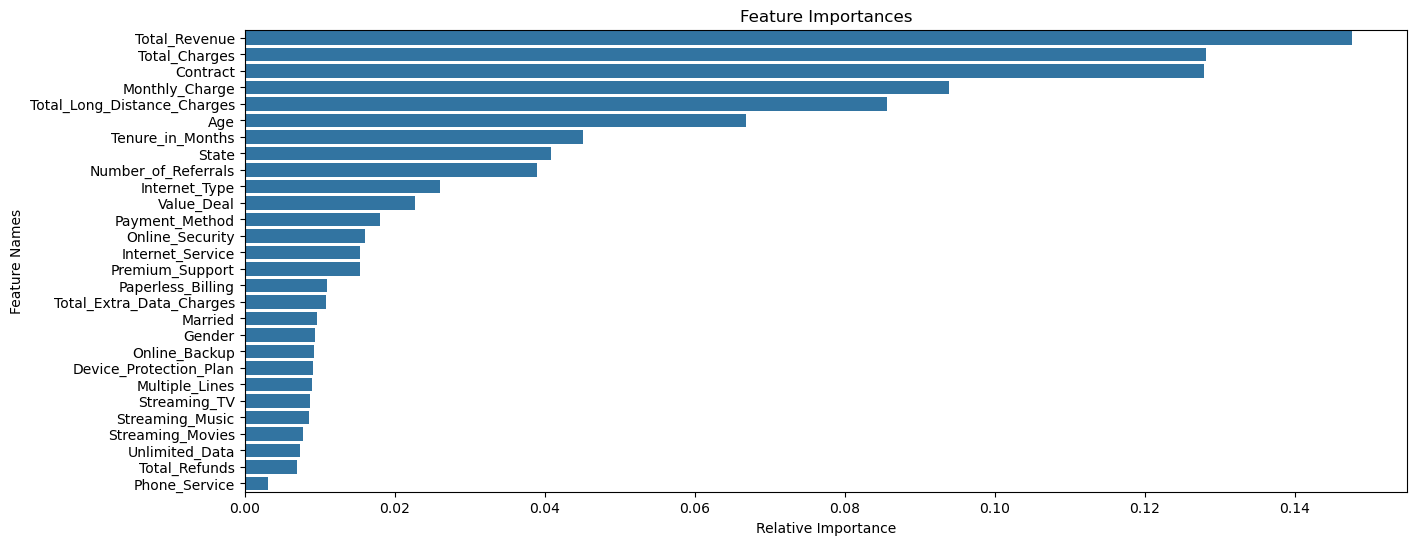

In [89]:
# Evaluate Model 
# Make predictions 
y_pred = rf_model.predict(X_test)

# Evaluate the model 
print("Confusion Matrix: ")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Feature Selection using Feature Importance 
importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances 
plt.figure(figsize=(15, 6))
sns.barplot(x=importances[indices], y=X.columns[indices])
plt.title('Feature Importances')
plt.xlabel('Relative Importance')
plt.ylabel('Feature Names')
plt.show()

In [97]:
# Predict on New Data 

# Define the path to the Joiner Data Excel file 
file_path = r"C:\Users\raman\OneDrive\School Related\Prediction_Data.xlsx"

# Define the shee name to read data from 
sheet_name = 'vw_JoinData'

# Read the data from the specified sheet into a pandas DataFrame 
new_data = pd.read_excel(file_path, sheet_name=sheet_name)

# Display the first few rows of the fetched data 
print(new_data.head())

# Retain the origincal DataFrame to preserve unencoded columns 
original_data = new_data.copy()

# Retain the Customer_ID column 
customer_ids = new_data['Customer_ID'] 

# Drop columsn that won't be used for prediction in the encoded DataFrame 
new_data = new_data.drop(['Customer_ID', 'Customer_Status', 'Churn_Category', 'Churn_Reason'], axis=1)

# Encode categorical variables using the saved Label encoders 
for column in new_data.select_dtypes(include=['object']).columns: 
    new_data[column] = label_encoders[column].transform(new_data[column])
    
# Make predictions 
new_predictions = rf_model.predict(new_data)

# Add predictions to the original DataFrame 
original_data['Customer_Status_Predicted'] = new_predictions

# Filter the DataFrame to include only records predicted as "Churned"
original_data = original_data[original_data['Customer_Status_Predicted'] == 1]

# Save the results 
original_data.to_csv(r"C:\Users\raman\OneDrive\School Related\Predictions.csv", index=False)

  Customer_ID  Gender  Age Married       State  Number_of_Referrals  \
0    11751-IL  Female   18      No    Illinois                    5   
1    13666-GA    Male   57     Yes     Georgia                   15   
2    16931-NJ  Female   39     Yes  New Jersey                    8   
3    22765-WI  Female   40     Yes   Wisconsin                    6   
4    22782-CA  Female   50     Yes  California                    2   

   Tenure_in_Months Value_Deal Phone_Service Multiple_Lines  ...  \
0                 7     Deal 5            No             No  ...   
1                16        NaN           Yes             No  ...   
2                23     Deal 5           Yes             No  ...   
3                16     Deal 5           Yes             No  ...   
4                28        NaN           Yes             No  ...   

    Payment_Method Monthly_Charge Total_Charges Total_Refunds  \
0     Mailed Check      61.310001     23.889999           0.0   
1  Bank Withdrawal     105.489998 